In [1]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from model import UNET
from dataloader import get_loaders_heatmaps
import FILE_PATHS
import pandas as pd
import numpy as np
from training_landmarks import(
    train, 
    plot_loss_curves
)


In [2]:
# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
NUM_EPOCHS = 5
NUM_WORKERS = 4
IMAGE_HEIGHT = 112
IMAGE_WIDTH = 112
PIN_MEMORY = True
LOAD_MODEL = False

filename = "../EchoNet-Dynamic/models/landmark_model.pth.tar"

In [3]:
# Transformations
train_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        # A.Rotate(limit=35, p=1.0),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

In [4]:
# MODEL
model = UNET(in_channels=3, out_channels=7).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [5]:
# BATCHES
train_loader, val_loader = get_loaders_heatmaps(
    FILE_PATHS.IMAGES,
    f"{FILE_PATHS.HEATMAPS}/gaussian",
    FILE_PATHS.MASKS,
    BATCH_SIZE,
    train_transforms,
    val_transforms,
    NUM_WORKERS,
    test_size=0.2,
    seed=42,
)

TRAIN PATHS LENGTHS: images, masks, heatmaps
1599, 1599, 1599
VALIDATION PATHS LENGTHS: images, masks, heatmaps
400, 400, 400


In [6]:
landmark_results = train(model=model, 
                        train_dataloader=train_loader,
                        test_dataloader=val_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        device=DEVICE)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0665 | train_acc: 0.0075 | test_loss: 0.0675 | test_acc: 0.0493


  0%|          | 0/5 [05:43<?, ?it/s]


TypeError: tensor or list of tensors expected, got <class 'numpy.ndarray'>

In [ ]:
torch.save(model.state_dict(), filename)

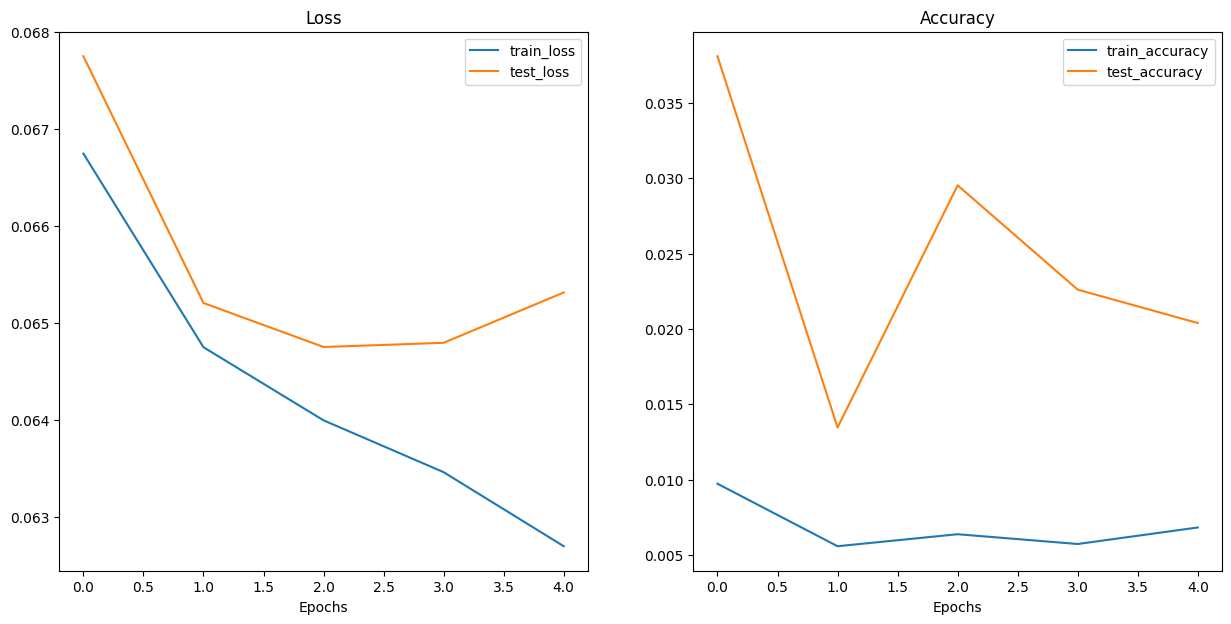

In [ ]:
plot_loss_curves(landmark_results)

In [ ]:
landmark_model = pd.DataFrame(landmark_results)
landmark_model.to_csv("landmark_model.csv")
